In [1]:
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features

from receptive_field import compute_proto_layer_rf_info_v2
import torch.nn.functional as F

base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}

def construct_PPNet(base_architecture, pretrained=True, img_size=128,
                    prototype_shape=(2000, 512, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck'):
    features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PPNet(features=features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type)

class PPNet(nn.Module):

    def __init__(self, features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=True,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck'):

        super(PPNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        
        
        # prototype_activation_function could be 'log', 'linear',
        # or a generic function that converts distance to similarity score
        self.prototype_activation_function = prototype_activation_function

        '''
        Here we are initializing the class identities of the prototypes
        Without domain specific knowledge we allocate the same number of
        prototypes for each class
        '''
        assert(self.num_prototypes % self.num_classes == 0)
        # a onehot indication matrix for each prototype's class identity
        self.prototype_class_identity = torch.zeros(self.num_prototypes,
                                                    self.num_classes)

        num_prototypes_per_class = self.num_prototypes // self.num_classes
        for j in range(self.num_prototypes):
            self.prototype_class_identity[j, j // num_prototypes_per_class] = 1

        self.proto_layer_rf_info = proto_layer_rf_info

        # this has to be named features to allow the precise loading
        self.features = features

        features_name = str(self.features).upper()
        if features_name.startswith('VGG') or features_name.startswith('RES'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.Conv2d)][-1].out_channels
        elif features_name.startswith('DENSE'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.BatchNorm2d)][-1].num_features
        else:
            raise Exception('other base base_architecture NOT implemented')

        if add_on_layers_type == 'bottleneck':
            add_on_layers = []
            current_in_channels = first_add_on_layer_in_channels
            while (current_in_channels > self.prototype_shape[1]) or (len(add_on_layers) == 0):
                current_out_channels = max(self.prototype_shape[1], (current_in_channels // 2))
                add_on_layers.append(nn.Conv2d(in_channels=current_in_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                add_on_layers.append(nn.ReLU())
                add_on_layers.append(nn.Conv2d(in_channels=current_out_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                if current_out_channels > self.prototype_shape[1]:
                    add_on_layers.append(nn.ReLU())
                else:
                    assert(current_out_channels == self.prototype_shape[1])
                    add_on_layers.append(nn.Sigmoid())
                current_in_channels = current_in_channels // 2
            self.add_on_layers = nn.Sequential(*add_on_layers)
        else:
            self.add_on_layers = nn.Sequential(
                nn.Conv2d(in_channels=first_add_on_layer_in_channels, out_channels=self.prototype_shape[1], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
                nn.Sigmoid()
                )
        
        self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
                                              requires_grad=True)

        # do not make this just a tensor,
        # since it will not be moved automatically to gpu
        self.ones = nn.Parameter(torch.ones(self.prototype_shape),
                                 requires_grad=False)

        self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
                                    bias=False) # do not use bias

        if init_weights:
            self._initialize_weights()

    def conv_features(self, x):
        '''
        The feature input to the prototype layer.
        '''
        # If the input has only 1 channel, repeat it to match the expected 3 channels.
        if x.size(1) == 1:
            x = torch.cat([x] * 3, dim=1)
        x = self.features(x)
        # Optionally remove a pooling layer here if necessary
        x = self.add_on_layers(x)
        return x
    
    @staticmethod
    def _weighted_l2_convolution(input, filter, weights):
        '''
        input of shape N * c * h * w
        filter of shape P * c * h1 * w1
        weight of shape P * c * h1 * w1
        '''
        input2 = input ** 2
        input_patch_weighted_norm2 = F.conv2d(input=input2, weight=weights)

        filter2 = filter ** 2
        weighted_filter2 = filter2 * weights
        filter_weighted_norm2 = torch.sum(weighted_filter2, dim=(1, 2, 3))
        filter_weighted_norm2_reshape = filter_weighted_norm2.view(-1, 1, 1)

        weighted_filter = filter * weights
        weighted_inner_product = F.conv2d(input=input, weight=weighted_filter)

        # use broadcast
        intermediate_result = \
            - 2 * weighted_inner_product + filter_weighted_norm2_reshape
        # x2_patch_sum and intermediate_result are of the same shape
        distances = F.relu(input_patch_weighted_norm2 + intermediate_result)

        return distances

    def _l2_convolution(self, x):
        '''
        apply self.prototype_vectors as l2-convolution filters on input x
        '''
        x2 = x ** 2
        x2_patch_sum = F.conv2d(input=x2, weight=self.ones)

        p2 = self.prototype_vectors ** 2
        p2 = torch.sum(p2, dim=(1, 2, 3))
        # p2 is a vector of shape (num_prototypes,)
        # then we reshape it to (num_prototypes, 1, 1)
        p2_reshape = p2.view(-1, 1, 1)

        xp = F.conv2d(input=x, weight=self.prototype_vectors)
        intermediate_result = - 2 * xp + p2_reshape  # use broadcast
        # x2_patch_sum and intermediate_result are of the same shape
        distances = F.relu(x2_patch_sum + intermediate_result)

        return distances

    def prototype_distances(self, x):
        '''
        x is the raw input
        '''
        conv_features = self.conv_features(x)
        distances = self._l2_convolution(conv_features)
        return distances

    def distance_2_similarity(self, distances):
        if self.prototype_activation_function == 'log':
            return torch.log((distances + 1) / (distances + self.epsilon))
        elif self.prototype_activation_function == 'linear':
            return -distances
        else:
            return self.prototype_activation_function(distances)


    def forward(self, x):
        distances = self.prototype_distances(x)
        min_distances = -F.max_pool2d(-distances, kernel_size=distances.size()[2:])
        min_distances = min_distances.view(-1, self.num_prototypes)
        prototype_activations = self.distance_2_similarity(min_distances)
        
        # No need to apply softmax, as we will use BCEWithLogitsLoss later
        logits = self.last_layer(prototype_activations)
        return logits, min_distances

    def push_forward(self, x):
        '''this method is needed for the pushing operation'''
        conv_output = self.conv_features(x)
        distances = self._l2_convolution(conv_output)
        return conv_output, distances

    def prune_prototypes(self, prototypes_to_prune):
        '''
        prototypes_to_prune: a list of indices each in
        [0, current number of prototypes - 1] that indicates the prototypes to
        be removed
        '''
        prototypes_to_keep = list(set(range(self.num_prototypes)) - set(prototypes_to_prune))

        self.prototype_vectors = nn.Parameter(self.prototype_vectors.data[prototypes_to_keep, ...],
                                              requires_grad=True)

        self.prototype_shape = list(self.prototype_vectors.size())
        self.num_prototypes = self.prototype_shape[0]

        # changing self.last_layer in place
        # changing in_features and out_features make sure the numbers are consistent
        self.last_layer.in_features = self.num_prototypes
        self.last_layer.out_features = self.num_classes
        self.last_layer.weight.data = self.last_layer.weight.data[:, prototypes_to_keep]

        # self.ones is nn.Parameter
        self.ones = nn.Parameter(self.ones.data[prototypes_to_keep, ...],
                                 requires_grad=False)
        # self.prototype_class_identity is torch tensor
        # so it does not need .data access for value update
        self.prototype_class_identity = self.prototype_class_identity[prototypes_to_keep, :]

    def __repr__(self):
        # PPNet(self, features, img_size, prototype_shape,
        # proto_layer_rf_info, num_classes, init_weights=True):
        rep = (
            'PPNet(\n'
            '\tfeatures: {},\n'
            '\timg_size: {},\n'
            '\tprototype_shape: {},\n'
            '\tproto_layer_rf_info: {},\n'
            '\tnum_classes: {},\n'
            '\tepsilon: {}\n'
            ')'
        )

        return rep.format(self.features,
                          self.img_size,
                          self.prototype_shape,
                          self.proto_layer_rf_info,
                          self.num_classes,
                          self.epsilon)

    def set_last_layer_incorrect_connection(self, incorrect_strength):
        '''
        the incorrect strength will be actual strength if -0.5 then input -0.5
        '''
        positive_one_weights_locations = torch.t(self.prototype_class_identity)
        negative_one_weights_locations = 1 - positive_one_weights_locations

        correct_class_connection = 1
        incorrect_class_connection = incorrect_strength
        self.last_layer.weight.data.copy_(
            correct_class_connection * positive_one_weights_locations
            + incorrect_class_connection * negative_one_weights_locations)

    def _initialize_weights(self):
        for m in self.add_on_layers.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.set_last_layer_incorrect_connection(incorrect_strength=-0.5)


def construct_PPNet(base_architecture, pretrained=True, img_size=64,
                    prototype_shape=(2000, 512, 1, 1), num_classes=2,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck'):
    features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PPNet(features=features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type)


# Multi-class Classification with PPNet Model Training

This Python code demonstrates the training of a PPNet model for multi-class classification on the MedMNIST dataset. The MedMNIST library is used to download and preprocess the data. The code includes the following steps:

1. **Data Loading and Preprocessing:** 
   - The code imports necessary libraries for data loading, including MedMNIST, Torch, and torchvision.
   - It sets parameters for the data such as the dataset flag ('pneumoniamnist'), batch sizes, and learning rates.
   - Data transformation pipelines are defined for normalization and conversion to tensors.

2. **Dataset Preparation:** 
   - The code loads the training and test datasets with different sizes (28x28, 128x128, and 224x224).
   - DataLoader objects are created for efficient batch processing.

3. **Model Initialization:** 
   - The PPNet model is instantiated with a base architecture of 'resnet18' and the number of classes set according to the dataset.

4. **Training Loop:** 
   - The code iterates over different sizes and learning rates.
   - For each size, it defines a loss function (BCEWithLogitsLoss) and an optimizer (Adam).
   - It trains the model for a fixed number of epochs, calculating and printing loss and accuracy for each epoch.

5. **Evaluation:** 
   - After training, the model is set to evaluation mode, but the evaluation loop is not shown in the provided code snippet.

6. **Result Analysis:** 
   - The code prints the training loss and accuracy for each epoch and size.

7. **PPNet Model Information:** 
   - The code snippet concludes by printing information about the PPNet model architecture and its parameters, such as the base features, image size, prototype shape, number of classes, and epsilon value.

Please note that the evaluation loop is mentioned but not included in the provided code snippet.


In [7]:
# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 5
BATCH_SIZE = {
    28: 32,
    64: 32
}
learning_rates = {
    28: 0.01,
    64: 0.001
}

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with different sizes
train_datasets = {}
test_datasets = {}
pil_datasets = {}
train_loaders = {}
train_loaders_at_eval = {}
test_loaders = {}

for size in [28, 64]:
    train_datasets[size] = DataClass(split='train', transform=data_transform, download=download, size=size)
    test_datasets[size] = DataClass(split='test', transform=data_transform, download=download, size=size)
    pil_datasets[size] = DataClass(split='train', download=download, size=size)
    
    train_loaders[size] = data.DataLoader(dataset=train_datasets[size], batch_size=BATCH_SIZE[size], shuffle=True)
    train_loaders_at_eval[size] = data.DataLoader(dataset=train_datasets[size], batch_size=2*BATCH_SIZE[size], shuffle=False)
    test_loaders[size] = data.DataLoader(dataset=test_datasets[size], batch_size=2*BATCH_SIZE[size], shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Training loop for different sizes and learning rates
for size in [28, 64]:
    lr = learning_rates[size]
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        epoch_predictions = []
        epoch_labels = []
        epoch_images = []
        
        for images, labels in train_loaders[size]:
            optimizer.zero_grad()
            outputs, _ = model(images)
            
            # Convert labels to one-hot encoded vectors
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Store predictions, labels, and images for epoch-level evaluation
            epoch_predictions.append(outputs.detach().cpu().numpy())
            epoch_labels.append(labels.numpy())
            epoch_images.extend(images)
        
        # Calculate accuracy for the epoch
        epoch_predictions = np.concatenate(epoch_predictions)
        epoch_labels = np.concatenate(epoch_labels)
        epoch_accuracy = (epoch_predictions.argmax(axis=1) == epoch_labels).mean()
        
        print(f"Size: {size}, Epoch {epoch+1}, Loss: {running_loss / len(train_loaders[size])}, ACC: {epoch_accuracy}")

Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Size: 28, Epoch 1, Loss: 0.6362612297808802, ACC: 0.7388493996732906
Size: 28, Epoch 2, Loss: 0.5789899121265154, ACC: 0.7421410365335599
Size: 28, Epoch 3, Loss: 0.5718837456928717, ACC: 0.7421410365335599
Size: 28, Epoch 4, Loss: 0.5758365044319952, ACC: 0.7421410365335599
Size: 28, Epoch 5, Loss: 0.5738000690534308, ACC: 0.7421410365335599
Size: 64, Epoch 1, Loss: 0.5702437583256412, ACC: 0.7421410365335599
Size: 64, Epoch 2, Loss: 0.5712552894208882, ACC: 0.7421410365335599
Size: 64, Epoch 

In [13]:
# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 10
BATCH_SIZE = {
    28: 128
}
learning_rates = {
    28: 0.002
}

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with different sizes
train_datasets = {}
test_datasets = {}
pil_datasets = {}
train_loaders = {}
train_loaders_at_eval = {}
test_loaders = {}

for size in [28]:
    train_datasets[size] = DataClass(split='train', transform=data_transform, download=download, size=size)
    test_datasets[size] = DataClass(split='test', transform=data_transform, download=download, size=size)
    pil_datasets[size] = DataClass(split='train', download=download, size=size)
    
    train_loaders[size] = data.DataLoader(dataset=train_datasets[size], batch_size=BATCH_SIZE[size], shuffle=True)
    train_loaders_at_eval[size] = data.DataLoader(dataset=train_datasets[size], batch_size=2*BATCH_SIZE[size], shuffle=False)
    test_loaders[size] = data.DataLoader(dataset=test_datasets[size], batch_size=2*BATCH_SIZE[size], shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Training loop for different sizes and learning rates
for size in [28]:
    lr = learning_rates[size]
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        epoch_predictions = []
        epoch_labels = []
        epoch_images = []
        
        for images, labels in train_loaders[size]:
            optimizer.zero_grad()
            outputs, _ = model(images)
            
            # Convert labels to one-hot encoded vectors
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Store predictions, labels, and images for epoch-level evaluation
            epoch_predictions.append(outputs.detach().cpu().numpy())
            epoch_labels.append(labels.numpy())
            epoch_images.extend(images)
        
        # Calculate accuracy for the epoch
        epoch_predictions = np.concatenate(epoch_predictions)
        epoch_labels = np.concatenate(epoch_labels)
        epoch_accuracy = (epoch_predictions.argmax(axis=1) == epoch_labels).mean()
        
        print(f"Size: {size}, Epoch {epoch+1}, Loss: {running_loss / len(train_loaders[size])}, ACC: {epoch_accuracy}")

Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Size: 28, Epoch 1, Loss: 1.2566972455462895, ACC: 0.7403923544515418
Size: 28, Epoch 2, Loss: 0.8285484313964844, ACC: 0.7421410365335599
Size: 28, Epoch 3, Loss: 0.6753030999286754, ACC: 0.7421410365335599
Size: 28, Epoch 4, Loss: 0.6014503546663232, ACC: 0.7421410365335599
Size: 28, Epoch 5, Loss: 0.5694807260423094, ACC: 0.7421410365335599
Size: 28, Epoch 6, Loss: 0.558705065701459, ACC: 0.7421410365335599
Size: 28, Epoch 7, Loss: 0.5597366070425188, ACC: 0.7421410365335599
Size: 28, Epoch 8, Loss: 0.5647323888701361, ACC: 0.7421410365335599
Size: 28, Epoch 9, Loss: 0.5569343341363443, ACC: 0.7421410365335599
Size: 28, Epoch 10, Loss: 0.5543757475711204, ACC: 0.7421410365335599


In [3]:
# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 10
BATCH_SIZE = 128
learning_rate = 0.003

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data for size 224
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=128)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=128)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        
        # Convert labels to one-hot encoded vectors
        batch_size = labels.size(0)
        one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
        for i in range(batch_size):
            one_hot_labels[i][labels[i]] = 1
        
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs, _ = model(images)
            
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            val_loss += criterion(outputs, one_hot_labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    val_loss /= len(test_loader)
    val_accuracy = 100.0 * correct / total
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_128.npz
Epoch 1, Train Loss: 1.5286, Val Loss: 1.2860, Val Accuracy: 7810.26%
Epoch 2, Train Loss: 1.0915, Val Loss: 1.1271, Val Accuracy: 7810.26%
Epoch 3, Train Loss: 0.9105, Val Loss: 1.0222, Val Accuracy: 7810.26%
Epoch 4, Train Loss: 0.8005, Val Loss: 0.9285, Val Accuracy: 7810.26%
Epoch 5, Train Loss: 0.7245, Val Loss: 0.8463, Val Accuracy: 7810.26%
Epoch 6, Train Loss: 0.6686, Val Loss: 0.7872, Val Accuracy: 7810.26%
Epoch 7, Train Loss: 0.6298, Val Loss: 0.7488, Val Accuracy: 7810.26%
Epoch 8, Train Loss: 0.6035, Val Loss: 0.7202, Val Accuracy: 7810.26%
Epoch 9, Train Loss: 0.5868, Val Loss: 0.7052, Val Accuracy: 7810.26%
Epoch 10, Train Loss: 0.5763, Val Loss: 0.6950, Val Accuracy: 7810.26%


Predicted Images:
Size: 28, Correctly Predicted Image: Ground Truth Label: 1, Predicted Label: 1


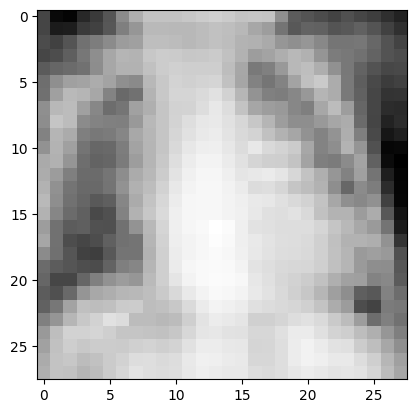

Size: 64, Correctly Predicted Image: Ground Truth Label: 1, Predicted Label: 1


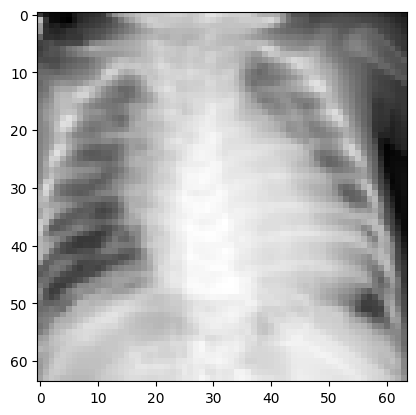

In [9]:
import random

# Evaluation loop
model.eval()

print("Predicted Images:")
for size in [28, 64]:
    correct_predicted_index = None
    
    for index, (images, labels) in enumerate(test_loaders[size]):
        outputs, _ = model(images)
        predictions = outputs.argmax(dim=1)
        
        # Find the index of the first correctly predicted image
        correct_mask = predictions == labels
        correct_predicted_index = torch.where(correct_mask)[0]
        
        # If a correct prediction is found, break the loop
        if correct_predicted_index.numel() > 0:
            correct_predicted_index = correct_predicted_index[0].item()
            break
    
    if correct_predicted_index is not None:
        correct_image = images[correct_predicted_index].squeeze().numpy()
        correct_label = labels[correct_predicted_index].item()
        correct_prediction = predictions[correct_predicted_index].item()
        
        print(f"Size: {size}, Correctly Predicted Image: Ground Truth Label: {correct_label}, Predicted Label: {correct_prediction}")
        plt.imshow(correct_image, cmap='gray')
        plt.show()

Predicted Images:
Image 1: Ground Truth Label: [1], Predicted Probabilities: [-1.0861746  1.0844561]


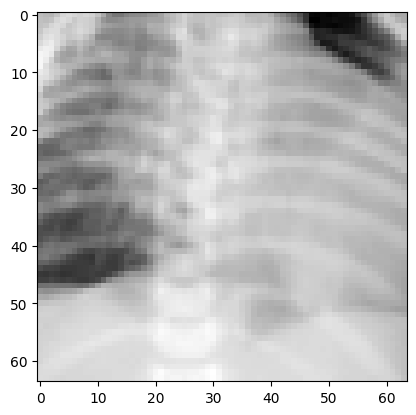

Image 2: Ground Truth Label: [0], Predicted Probabilities: [-1.111752   1.1103449]


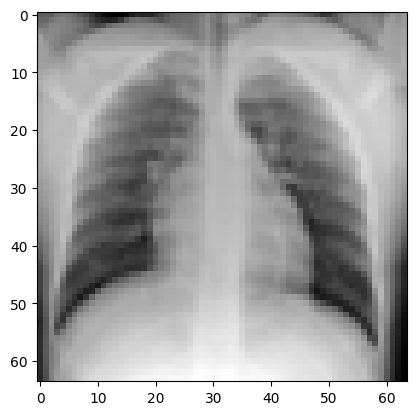

Image 3: Ground Truth Label: [1], Predicted Probabilities: [-0.95888853  0.9621253 ]


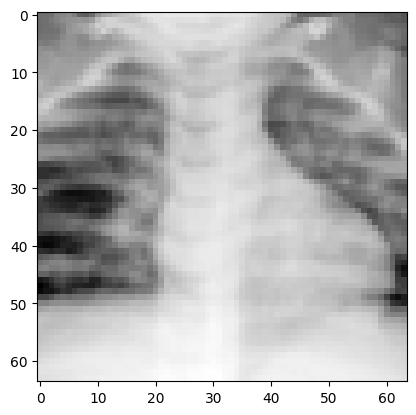

Image 4: Ground Truth Label: [1], Predicted Probabilities: [-1.0591197  1.0595365]


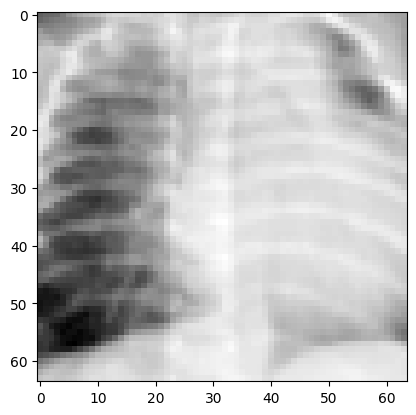

Image 5: Ground Truth Label: [1], Predicted Probabilities: [-1.0468794  1.0477687]


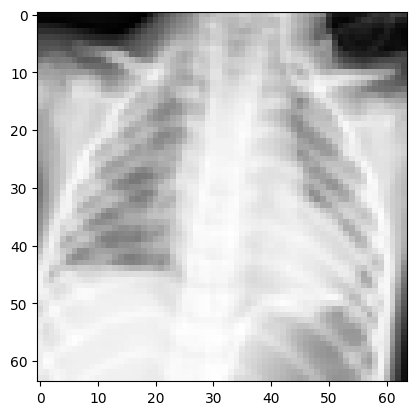

In [12]:
# Select some random images for printing
print("Predicted Images:")
for i in range(5):  # Adjust the number of images to print
    index = random.randint(0, len(epoch_images) - 1)
    image = epoch_images[index].numpy()
    label = epoch_labels[index]
    prediction = epoch_predictions[index]
    
    print(f"Image {i+1}: Ground Truth Label: {label}, Predicted Probabilities: {prediction}")
    # Print or visualize the image using imshow from matplotlib.pyplot
    plt.imshow(image.squeeze(), cmap='gray') 
    plt.show()

# RetinaMNIST 224
## Ordinal Regression (5)	

In [5]:
data_flag = 'retinamnist'
download = True

NUM_EPOCHS = 5
BATCH_SIZE = 128
lr = 0.002 

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 127992567/127992567 [00:34<00:00, 3722985.50it/s]


Using downloaded and verified file: C:\Users\Pooriya\.medmnist\retinamnist_224.npz


100%|██████████| 3291041/3291041 [00:01<00:00, 2225505.82it/s]


In [6]:
# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=5)  # Adjust num_classes as needed

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_predictions = []
    epoch_labels = []
    epoch_images = []
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        
        # Convert labels to one-hot encoded vectors
        batch_size = labels.size(0)
        one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
        for i in range(batch_size):
            one_hot_labels[i][labels[i]] = 1
            
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Store predictions, labels, and images for epoch-level evaluation
        epoch_predictions.append(outputs.detach().cpu().numpy())
        epoch_labels.append(labels.numpy())
        epoch_images.extend(images)
    
    # Calculate accuracy for the epoch
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_labels = np.concatenate(epoch_labels)
    epoch_accuracy = (epoch_predictions.argmax(axis=1) == epoch_labels).mean()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {epoch_accuracy}")

Epoch 1, Loss: 0.7717540529039171, ACC: 0.4093398491083676
Epoch 2, Loss: 0.5127904978063371, ACC: 0.45
Epoch 3, Loss: 0.48889248900943333, ACC: 0.45
Epoch 4, Loss: 0.47245179613431293, ACC: 0.45
Epoch 5, Loss: 0.46028851800494724, ACC: 0.45


PPNet(
	features: resnet18_features,
	img_size: 224,
	prototype_shape: (2000, 512, 1, 1),
	proto_layer_rf_info: [7, 32, 435, 0.5],
	num_classes: 5,
	epsilon: 0.0001
)

# PneumoniaMNIST 

- Trying several Learning Rates

In [8]:
def evaluate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [37]:
# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 10
BATCH_SIZES = [64, 128, 256]
LEARNING_RATES = [0.001, 0.002, 0.003]

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with size 28
size = 28
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=size)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=size)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Training loop for different batch sizes and learning rates
for batch_size in BATCH_SIZES:
    for lr in LEARNING_RATES:
        # Define loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(NUM_EPOCHS):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs, _ = model(images)
                
                # Convert labels to one-hot encoded vectors
                batch_size = labels.size(0)
                one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
                for i in range(batch_size):
                    one_hot_labels[i][labels[i]] = 1
                
                loss = criterion(outputs, one_hot_labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            # Calculate accuracy for the epoch
            accuracy = evaluate_accuracy(model, test_loader)
            
            print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {accuracy}")


Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Batch Size: 100, Learning Rate: 0.001, Epoch 1, Loss: 1.4197026265634072, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 2, Loss: 1.0564018616805206, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 3, Loss: 0.8797515179659869, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 4, Loss: 0.7767651306616293, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 5, Loss: 0.703940333546819, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 6, Loss: 0.6515259017815461, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 7, Loss: 0.6155654191970825, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 8, Loss: 0.5926119459641946, ACC: 78.1025641025641
Batch Size: 100, Learning Rate: 0.001, Epoch 9, Loss: 0.5781655738482

In [11]:
import torch.optim.lr_scheduler as lr_scheduler

# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 10
BATCH_SIZES = [128]
LEARNING_RATES = [0.001, 0.002, 0.003]

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with size 28
size = 28
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=size)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=size)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

import torch.optim.lr_scheduler as lr_scheduler

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Training loop for different batch sizes and learning rates
for lr in LEARNING_RATES:
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(images)
            
            # Convert labels to one-hot encoded vectors
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate accuracy for the epoch
        accuracy = evaluate_accuracy(model, test_loader)
        print(f"Learning Rate: {lr}, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {accuracy}")
        
        # Adjust learning rate based on accuracy
        scheduler.step(accuracy)


Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist.npz
Learning Rate: 0.001, Epoch 1, Loss: 1.4235474354511983, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 2, Loss: 1.0620217661599856, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 3, Loss: 0.8833749680905729, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 4, Loss: 0.7810908604312587, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 5, Loss: 0.7081536908407469, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 6, Loss: 0.6771678586263914, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 7, Loss: 0.6714588145951967, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 8, Loss: 0.6671336679845243, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 9, Loss: 0.6627565203486262, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 10, Loss: 0.6595600778992111, ACC: 78.1025641025641
Learning Rate: 0.002, Epoch 1, Loss: 0.608786

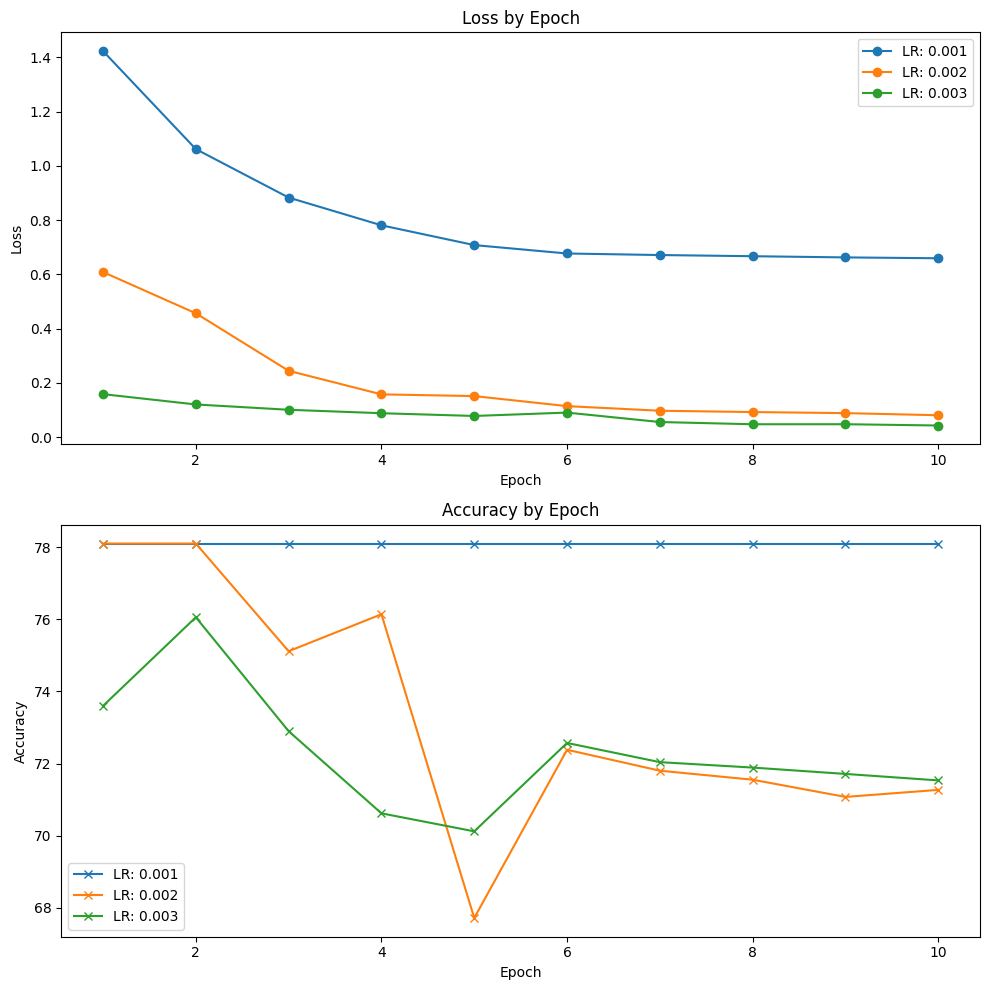

In [20]:
import matplotlib.pyplot as plt

# Extracted actual results
actual_results = [
    (0.001, [1.4235474354511983, 1.0620217661599856, 0.8833749680905729, 0.7810908604312587, 0.7081536908407469,
             0.6771678586263914, 0.6714588145951967, 0.6671336679845243, 0.6627565203486262, 0.6595600778992111],
     [78.1025641025641, 78.1025641025641, 78.1025641025641, 78.1025641025641, 78.1025641025641, 78.1025641025641,
      78.1025641025641, 78.1025641025641, 78.1025641025641, 78.1025641025641]),
    (0.002, [0.6087862607595083, 0.4566256742219667, 0.24465424305683858, 0.1577869587250658, 0.15142357208438822,
             0.11439725635824977, 0.09743838072628588, 0.09254876463799863, 0.08858615361355446, 0.0808072222044339],
     [78.1025641025641, 78.1025641025641, 75.11538461538461, 76.14102564102564, 67.71474358974359, 72.38141025641026,
      71.80128205128206, 71.55128205128206, 71.07371794871794, 71.26923076923077]),
    (0.003, [0.15860598292705175, 0.1205432354598432, 0.10096512442907772, 0.08825936153329708, 0.07814585739696348,
             0.09057660063577665, 0.05577745203029465, 0.04754827070880581, 0.047684977988939024, 0.0429702601269693],
     [73.59935897435898, 76.0576923076923, 72.8974358974359, 70.61858974358974, 70.11858974358974, 72.57051282051282,
      72.03846153846153, 71.88782051282051, 71.71153846153847, 71.53205128205128])
]

# Plotting loss and accuracy in separate subplots
fig, axs = plt.subplots(2, figsize=(10, 10))

for lr, losses, _ in actual_results:
    epochs = range(1, len(losses) + 1)
    axs[0].plot(epochs, losses, label=f'LR: {lr}', marker='o')

for lr, _, accs in actual_results:
    epochs = range(1, len(accs) + 1)
    axs[1].plot(epochs, accs, label=f'LR: {lr}', marker='x')

# Set titles and labels
axs[0].set_title('Loss by Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_title('Accuracy by Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

# Add legends
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


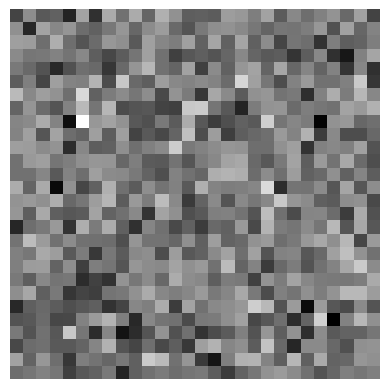

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the activation maximization function
def activate_maximize(model, target_neuron, num_iterations=100, lr=0.1):
    model.eval()
    image = torch.randn(1, 1, 28, 28, requires_grad=True)  # Random input image
    optimizer = optim.SGD([image], lr=lr)
    
    for _ in range(num_iterations):
        optimizer.zero_grad()
        _, output = model(image)  # Modify this line to unpack the output tuple
        activation = output[0, target_neuron]  # Activation of the target neuron
        activation.backward()
        optimizer.step()
    
    return image

# Select the target neuron to visualize
target_neuron = 0  # Change this to the desired target neuron index

# Perform activation maximization
image = activate_maximize(model, target_neuron)

# Convert the generated image to a numpy array for visualization
image = image.detach().squeeze().numpy()

# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 5
BATCH_SIZE = 128
lr = 0.001 

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

pil_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet50', num_classes=2)  # Adjust num_classes as needed

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_predictions = []
    epoch_labels = []
    epoch_images = []
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        
        # Convert labels to one-hot encoded vectors
        batch_size = labels.size(0)
        one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
        for i in range(batch_size):
            one_hot_labels[i][labels[i]] = 1
            
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Store predictions, labels, and images for epoch-level evaluation
        epoch_predictions.append(outputs.detach().cpu().numpy())
        epoch_labels.append(labels.numpy())
        epoch_images.extend(images)
    
    # Calculate accuracy for the epoch
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_labels = np.concatenate(epoch_labels)
    epoch_accuracy = (epoch_predictions.argmax(axis=1) == epoch_labels).mean()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {epoch_accuracy}")

Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Epoch 1, Loss: 1.3862313483212445, ACC: 0.733500489775353


KeyboardInterrupt: 

In [3]:
data_flag = 'retinamnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 128
lr = 0.001 

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet101', num_classes=5)  # Adjust num_classes as needed

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_predictions = []
    epoch_labels = []
    epoch_images = []
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        
        # Convert labels to one-hot encoded vectors
        batch_size = labels.size(0)
        one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
        for i in range(batch_size):
            one_hot_labels[i][labels[i]] = 1
            
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Store predictions, labels, and images for epoch-level evaluation
        epoch_predictions.append(outputs.detach().cpu().numpy())
        epoch_labels.append(labels.numpy())
        epoch_images.extend(images)
    
    # Calculate accuracy for the epoch
    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_labels = np.concatenate(epoch_labels)
    epoch_accuracy = (epoch_predictions.argmax(axis=1) == epoch_labels).mean()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {epoch_accuracy}")

100%|██████████| 13200879/13200879 [00:22<00:00, 593352.06it/s] 


Using downloaded and verified file: C:\Users\Pooriya\.medmnist\retinamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\retinamnist.npz
Epoch 1, Loss: 0.5894198616345724, ACC: 0.41491598079561043
Epoch 2, Loss: 0.5301630232069228, ACC: 0.45


In [5]:
import torch.optim.lr_scheduler as lr_scheduler

# Data parameters
data_flag = 'retinamnist'
download = True

# Model parameters
NUM_EPOCHS = 20
BATCH_SIZES = [128]
LEARNING_RATES = [0.001, 0.002, 0.003]

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with size 64
size = 64
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=size)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=size)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

import torch.optim.lr_scheduler as lr_scheduler

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet101', num_classes=5)  # Adjust num_classes as needed

# Training loop for different batch sizes and learning rates
for lr in LEARNING_RATES:
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(images)
            
            # Convert labels to one-hot encoded vectors
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate accuracy for the epoch
        accuracy = evaluate_accuracy(model, test_loader)
        print(f"Learning Rate: {lr}, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {accuracy}")
        
        # Adjust learning rate based on accuracy
        scheduler.step(accuracy)


Using downloaded and verified file: C:\Users\Pooriya\.medmnist\retinamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\retinamnist_64.npz
Learning Rate: 0.001, Epoch 1, Loss: 0.585568924744924, ACC: 53.16
Learning Rate: 0.001, Epoch 2, Loss: 0.5299056635962592, ACC: 53.16
Learning Rate: 0.001, Epoch 3, Loss: 0.5113183856010437, ACC: 53.16
Learning Rate: 0.001, Epoch 4, Loss: 0.49695344434844124, ACC: 53.16
Learning Rate: 0.001, Epoch 5, Loss: 0.4839254319667816, ACC: 53.16
Learning Rate: 0.001, Epoch 6, Loss: 0.47706370883517796, ACC: 53.16
Learning Rate: 0.001, Epoch 7, Loss: 0.4754418200916714, ACC: 53.16
Learning Rate: 0.001, Epoch 8, Loss: 0.47617373863856, ACC: 53.16
Learning Rate: 0.001, Epoch 9, Loss: 0.4729380077785916, ACC: 53.16
Learning Rate: 0.001, Epoch 10, Loss: 0.47334696186913383, ACC: 53.16
Learning Rate: 0.001, Epoch 11, Loss: 0.47314414381980896, ACC: 53.16
Learning Rate: 0.001, Epoch 12, Loss: 0.473129047287835, ACC: 53.16
Learning Rate: 0.

Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\Pooriya\.medmnist\pneumoniamnist_64.npz
Learning Rate: 0.001, Epoch 1, Loss: 1.4302250017990936, ACC: 78.1025641025641
Learning Rate: 0.001, Epoch 2, Loss: 1.059049946230811, ACC: 78.1025641025641


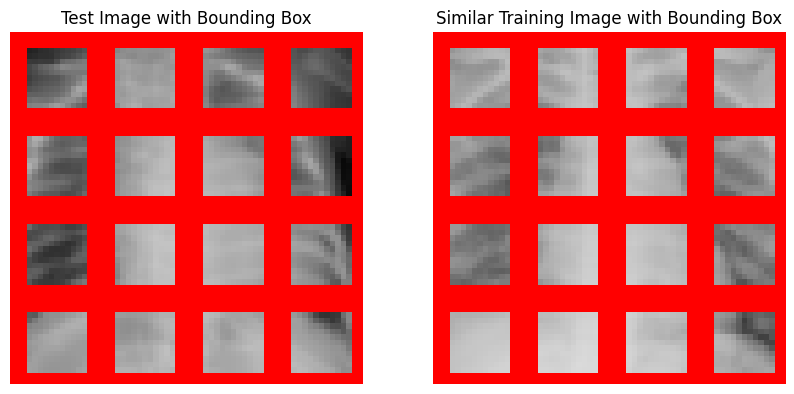

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import medmnist
import torch.optim.lr_scheduler as lr_scheduler

# Data parameters
data_flag = 'pneumoniamnist'
download = True

# Model parameters
NUM_EPOCHS = 2
BATCH_SIZES = [128]
LEARNING_RATES = [0.001]

# Get dataset information
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# Get the data class
DataClass = getattr(medmnist, info['python_class'])

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data with size 64
size = 64
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=size)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=size)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Instantiate the PPNet model
model = construct_PPNet(base_architecture='resnet18', num_classes=2)  # Adjust num_classes as needed

# Training loop for different batch sizes and learning rates
for lr in LEARNING_RATES:
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(images)
            
            # Convert labels to one-hot encoded vectors
            batch_size = labels.size(0)
            one_hot_labels = torch.zeros(batch_size, n_classes, dtype=torch.float32)
            for i in range(batch_size):
                one_hot_labels[i][labels[i]] = 1
            
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate accuracy for the epoch
        accuracy = evaluate_accuracy(model, test_loader)
        print(f"Learning Rate: {lr}, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, ACC: {accuracy}")
        
        # Adjust learning rate based on accuracy
        scheduler.step(accuracy)

# Function to convert tensor to PIL image
def tensor_to_pil(image_tensor):
    if image_tensor.shape[0] == 1:
        # If single-channel, duplicate to create 3 channels
        image_tensor = torch.cat([image_tensor] * 3, dim=0)
    image = image_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    image = (image * 0.5 + 0.5) * 255  # Unnormalize
    image = image.astype(np.uint8)
    return Image.fromarray(image)


# Function to draw bounding box around patches
def draw_bounding_box(image, patch_size, patch_coordinates, color='red'):
    image = tensor_to_pil(image)
    draw = ImageDraw.Draw(image)
    for x, y in patch_coordinates:
        draw.rectangle([x, y, x + patch_size, y + patch_size], outline=color, width=3)
    return image


# Rescale bounding box coordinates to match resized images
def rescale_coordinates(coordinates, original_size, target_size):
    scale_factor = target_size / original_size
    return [(int(coord[0] * scale_factor), int(coord[1] * scale_factor)) for coord in coordinates]

# Select a test image
test_image_index = 0
test_image, test_label = test_dataset[test_image_index]
test_image_class = test_label.item()

# Find images in training dataset belonging to the same class
similar_images_indices = [idx for idx, (_, label) in enumerate(train_dataset) if label.item() == test_image_class]

# Pick a random image from similar images
similar_image_index = np.random.choice(similar_images_indices)
similar_image, _ = train_dataset[similar_image_index]

# Get bounding box coordinates from the test image
test_image_patches = [(x, y) for x in range(0, size, 16) for y in range(0, size, 16)]
test_bounding_box_image = draw_bounding_box(test_image, 16, test_image_patches)

# Get bounding box coordinates from the similar training image
similar_image_patches = [(x, y) for x in range(0, size, 16) for y in range(0, size, 16)]
similar_bounding_box_image = draw_bounding_box(similar_image, 16, similar_image_patches)

# Rescale coordinates
test_bounding_box_image = test_bounding_box_image.resize((size, size))
similar_bounding_box_image = similar_bounding_box_image.resize((size, size))

# Plot images with bounding boxes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_bounding_box_image)
axes[0].set_title('Test Image with Bounding Box')
axes[0].axis('off')
axes[1].imshow(similar_bounding_box_image)
axes[1].set_title('Similar Training Image with Bounding Box')
axes[1].axis('off')
plt.show()


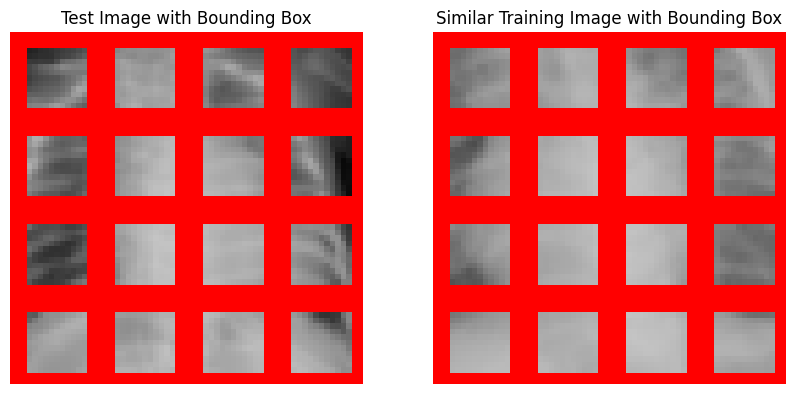

In [23]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

# Select a test image
test_image_index = 0
test_image, test_label = test_dataset[test_image_index]
test_image_class = test_label.item()

# Find images in training dataset belonging to the same class
similar_images_indices = [idx for idx, (_, label) in enumerate(train_dataset) if label.item() == test_image_class]

# Pick a random image from similar images
similar_image_index = np.random.choice(similar_images_indices)
similar_image, _ = train_dataset[similar_image_index]

# Function to convert tensor to PIL image
def tensor_to_pil(image_tensor):
    if image_tensor.shape[0] == 1:
        # If single-channel, duplicate to create 3 channels
        image_tensor = torch.cat([image_tensor] * 3, dim=0)
    image = image_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    image = (image * 0.5 + 0.5) * 255  # Unnormalize
    image = image.astype(np.uint8)
    return Image.fromarray(image)


# Function to draw bounding box around patches
def draw_bounding_box(image, patch_size, patch_coordinates, color='red'):
    image = tensor_to_pil(image)
    draw = ImageDraw.Draw(image)
    for x, y in patch_coordinates:
        draw.rectangle([x, y, x + patch_size, y + patch_size], outline=color, width=3)
    return image


# Rescale bounding box coordinates to match resized images
def rescale_coordinates(coordinates, original_size, target_size):
    scale_factor = target_size / original_size
    return [(int(coord[0] * scale_factor), int(coord[1] * scale_factor)) for coord in coordinates]

# Get bounding box coordinates from the test image
test_image_patches = [(x, y) for x in range(0, size, 16) for y in range(0, size, 16)]
test_bounding_box_image = draw_bounding_box(test_image, 16, test_image_patches)

# Get bounding box coordinates from the similar training image
similar_image_patches = [(x, y) for x in range(0, size, 16) for y in range(0, size, 16)]
similar_bounding_box_image = draw_bounding_box(similar_image, 16, similar_image_patches)

# Rescale coordinates
test_bounding_box_image = test_bounding_box_image.resize((size, size))
similar_bounding_box_image = similar_bounding_box_image.resize((size, size))

# Plot images with bounding boxes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_bounding_box_image)
axes[0].set_title('Test Image with Bounding Box')
axes[0].axis('off')
axes[1].imshow(similar_bounding_box_image)
axes[1].set_title('Similar Training Image with Bounding Box')
axes[1].axis('off')
plt.show()
